In [21]:
import socket
from Utils import PklsFolder
import pandas as pd
from pathlib import Path
from tqdm import tqdm
from scapy.all import *
import numpy as np

In [2]:
def dataframe_from_csv(target):
    return pd.read_csv(target,encoding='cp1252').rename(columns=lambda x: x.strip()).dropna(subset=['Flow ID'], how='all')

def dataframe_from_csvs(targets):
    return pd.concat([dataframe_from_csv(x) for x in targets])

def split_ben_mal_DF(Day_DF):
    fwd_Benign_DF = Day_DF[Day_DF['Label'] == 'BENIGN'][['Source IP', 'Source Port', 'Destination IP', 'Destination Port', 'Protocol','Label','Timestamp']]
    bwd_Benign_DF = Day_DF[Day_DF['Label'] == 'BENIGN'][['Destination IP', 'Destination Port','Source IP', 'Source Port',  'Protocol','Label','Timestamp']]
    bwd_Benign_DF.columns = ['Source IP', 'Source Port', 'Destination IP', 'Destination Port', 'Protocol','Label','Timestamp']
    Benign_DF = pd.concat([fwd_Benign_DF, bwd_Benign_DF]).drop_duplicates(subset = ['Source IP', 'Source Port', 'Destination IP', 'Destination Port', 'Protocol','Label'], keep = 'first').reset_index(drop = True)
    
    fwd_Mal_DF = Day_DF[Day_DF['Label'] != 'BENIGN'][['Source IP', 'Source Port', 'Destination IP', 'Destination Port', 'Protocol','Label','Timestamp']]
    bwd_Mal_DF = Day_DF[Day_DF['Label'] != 'BENIGN'][['Destination IP', 'Destination Port','Source IP', 'Source Port', 'Protocol','Label','Timestamp']]
    bwd_Mal_DF.columns = ['Source IP', 'Source Port', 'Destination IP', 'Destination Port', 'Protocol','Label','Timestamp']
    Mal_DF = pd.concat([fwd_Mal_DF,bwd_Mal_DF]).drop_duplicates(subset = ['Source IP', 'Source Port', 'Destination IP', 'Destination Port', 'Protocol','Label'], keep = 'first').reset_index(drop = True)

    return Benign_DF, Mal_DF

def drop_dup_btw_df(df1, df2):
    tmp = pd.concat([df1,df2]).reset_index(drop = True)
    dup_index = tmp[tmp.duplicated(subset = ['Source IP','Source Port','Destination IP', 'Destination Port', 'Protocol'], keep = 'last')].index
    dup_index = dup_index[dup_index < len(df1)]
    return df1.drop(index = dup_index)

In [3]:
week = ['Monday','Tuesday','Wednesday','Thursday','Friday']

Benign_DF = pd.DataFrame()
Mal_DF = pd.DataFrame()

for day in week: 
    day_csv= sorted([x for x in Path('../../dataset/CICIDS2017/flow_label/TrafficLabelling').glob(f'{day}-*.csv')],reverse = True)
    day_DF_RAW = dataframe_from_csvs(day_csv)
    day_DF = day_DF_RAW.drop_duplicates(subset = ['Source IP', 'Source Port', 'Destination IP', 'Destination Port', 'Protocol','Label'], keep = 'first')

    B_DF ,M_DF = split_ben_mal_DF(day_DF)
    PB_DF = drop_dup_btw_df(B_DF,M_DF)
    
    Benign_DF = pd.concat([Benign_DF,PB_DF])
    Mal_DF = pd.concat([Mal_DF, M_DF])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DtypeWarning: Columns (0,1,3,6,84) have mixed types.Specify dtype option on import or set low_memory=False.
  


In [4]:
pkls_dir = '../../dataset/CICIDS2017/pkls'
flow_dataset = PklsFolder(pkls_dir)

In [12]:
null_list = []
for i in tqdm(range(len(flow_dataset))):
    flow, label = flow_dataset[i]
    
    if flow == []:
        null_list.append(i)
        


 62%|██████▏   | 1671220/2679226 [00:28<00:22, 45288.39it/s]


100%|██████████| 2679226/2679226 [00:45<00:00, 59326.05it/s]


In [22]:
np.save('./ISCX2017_null_index.npy', np.array(null_list))

In [15]:
null_class_list = []

for i in null_list:
    flow, label = flow_dataset[i]
    null_class_list.append(label)
    

In [93]:
null_class = {}
for label, cnt in pd.Series(null_class_list).value_counts().items():
    null_class[label] = cnt

In [100]:
attack_class_list = ['FTP-Patator', 'SSH-Patator', 'DoS slowloris','DoS Slowhttptest', 'DoS Hulk', 'DoS GoldenEye', 'Heartbleed','Infiltration', 'Web Attack – Brute Force', 'Web Attack – XSS','Web Attack – Sql Injection', 'DDoS', 'PortScan', 'Bot']
attack_class = {flow : i+1 for i, flow in enumerate(attack_class_list)}

flow_cnt = flow_dataset.data_cnt_per_class()

for label, cnt in null_class.items() :
    flow_cnt[str(label)] -= cnt

mal_cnt = 0
for i in range(1,15):
    mal_cnt += flow_cnt[str(i)]

In [124]:
print(f'Benign flow count : {flow_cnt[str(0)]}')

Benign flow count : 2191361


In [125]:
print(f'Malicious flow count : {mal_cnt}')

Malicious flow count : 482733


In [128]:
null_class

{4: 2860, 3: 1663, 13: 528, 5: 81}

In [106]:
flow_cnt

{'0': 2191361,
 '1': 7982,
 '2': 5958,
 '3': 6083,
 '4': 5572,
 '5': 28135,
 '6': 14916,
 '7': 1,
 '8': 12,
 '9': 2726,
 '10': 1262,
 '11': 24,
 '12': 90784,
 '13': 316822,
 '14': 2456}

In [79]:
ben_5tup = {'Source IP' : [], 'Source Port' : [], 'Destination IP' : [], 'Destination Port' : [], 'Protocol' : []}
mal_5tup = {'Source IP' : [], 'Source Port' : [], 'Destination IP' : [], 'Destination Port' : [], 'Protocol' : []}


for i in tqdm(range(len(flow_dataset))):
    flow, label = flow_dataset[i]
    
    if i in null_list:
        continue
        
    elif label == 0:
        pck = Ether(flow[0])
        ben_5tup['Source IP'].append(pck['IP'].src)
        ben_5tup['Source Port'].append(pck.sport)
        ben_5tup['Destination IP'].append(pck['IP'].dst)
        ben_5tup['Destination Port'].append(pck.dport)
        ben_5tup['Protocol'].append(str(pck.layers()[2]).split('.')[-1][:3])
            
    elif label != 0:
        pck = Ether(flow[0])
        mal_5tup['Source IP'].append(pck['IP'].src)
        mal_5tup['Source Port'].append(pck.sport)
        mal_5tup['Destination IP'].append(pck['IP'].dst)
        mal_5tup['Destination Port'].append(pck.dport)
        mal_5tup['Protocol'].append(str(pck.layers()[2]).split('.')[-1][:3])


  2%|▏         | 55923/2679226 [00:27<20:40, 2114.40it/s]


  4%|▍         | 113104/2679226 [00:55<19:54, 2148.24it/s]


  6%|▋         | 168534/2679226 [01:22<21:05, 1983.67it/s]


  8%|▊         | 204767/2679226 [01:50<39:44, 1037.58it/s]


  9%|▊         | 230935/2679226 [02:19<40:02, 1019.04it/s]


 10%|▉         | 263817/2679226 [02:47<44:09, 911.63it/s]


 11%|█         | 292541/2679226 [03:16<33:07, 1201.04it/s]


 13%|█▎        | 341229/2679226 [03:47<19:28, 2001.00it/s]


 14%|█▍        | 377548/2679226 [04:16<22:21, 1716.37it/s]


 16%|█▌        | 427635/2679226 [04:44<19:03, 1969.73it/s]


 18%|█▊        | 479760/2679226 [05:11<18:57, 1932.96it/s]


 20%|█▉        | 532012/2679226 [05:38<18:43, 1910.54it/s]


 22%|██▏       | 584841/2679226 [06:05<17:21, 2010.80it/s]


 24%|██▍       | 638306/2679226 [06:33<16:27, 2067.18it/s]


 25%|██▍       | 664768/2679226 [07:02<54:19, 617.95it/s]  


 26%|██▌       | 693386/2679226 [07:32<43:18, 764.36it/s]


 27%|██▋       | 719304/2679226 [08:01<33:21, 979.45it/s] 


 28%|██▊       | 746949/2679226 [08:30<33:27, 962.35it/s]


 29%|██▉       | 777207/2679226 [08:59<29:46, 1064.62it/s]


 31%|███       | 825858/2679226 [09:26<13:33, 2277.36it/s]


 33%|███▎      | 885852/2679226 [09:54<13:21, 2237.45it/s]


 35%|███▌      | 942616/2679226 [10:21<13:34, 2131.87it/s]


 37%|███▋      | 998935/2679226 [10:48<12:38, 2214.84it/s]


 39%|███▉      | 1047113/2679226 [11:15<15:31, 1751.81it/s]


 41%|████      | 1093073/2679226 [11:41<15:15, 1731.93it/s]


 43%|████▎     | 1140988/2679226 [12:08<14:36, 1754.40it/s]


 44%|████▍     | 1183966/2679226 [12:34<18:50, 1322.22it/s]


 46%|████▌     | 1219401/2679226 [13:03<23:04, 1054.60it/s]


 47%|████▋     | 1252653/2679226 [13:32<29:53, 795.57it/s]


 48%|████▊     | 1274457/2679226 [14:00<29:17, 799.52it/s]


 48%|████▊     | 1296333/2679226 [14:27<28:50, 799.22it/s]


 49%|████▉     | 1318158/2679226 [14:55<27:55, 812.48it/s]


 50%|█████     | 1340033/2679226 [15:23<27:25, 813.83it/s]


 52%|█████▏    | 1384158/2679226 [15:49<12:20, 1747.87it/s]


 53%|█████▎    | 1425558/2679226 [16:16<09:35, 2177.91it/s]


 55%|█████▍    | 1461060/2679226 [16:45<20:06, 1009.44it/s]


 55%|█████▌    | 1486074/2679226 [17:13<25:03, 793.70it/s]


 56%|█████▋    | 1508432/2679226 [17:41<22:17, 875.10it/s]


 57%|█████▋    | 1530967/2679226 [18:08<22:15, 859.76it/s]


 58%|█████▊    | 1559687/2679226 [18:37<22:52, 815.66it/s]


 60%|█████▉    | 1606505/2679226 [19:04<08:25, 2122.76it/s]


 62%|██████▏   | 1663454/2679226 [19:30<08:16, 2045.82it/s]


 64%|██████▍   | 1719753/2679226 [19:58<07:20, 2177.66it/s]


 66%|██████▌   | 1770490/2679226 [20:25<08:39, 1748.69it/s]


 68%|██████▊   | 1816547/2679226 [20:51<08:13, 1746.80it/s]


 70%|██████▉   | 1862114/2679226 [21:18<07:57, 1711.81it/s]


 71%|███████   | 1900596/2679226 [21:47<11:59, 1082.88it/s]


 72%|███████▏  | 1929807/2679226 [22:15<15:02, 830.74it/s]


 73%|███████▎  | 1952566/2679226 [22:43<14:28, 836.40it/s]


 74%|███████▍  | 1981073/2679226 [23:11<05:18, 2193.87it/s]


 75%|███████▍  | 2004426/2679226 [23:38<13:50, 812.83it/s]


 76%|███████▌  | 2042668/2679226 [24:06<05:33, 1906.56it/s]


 78%|███████▊  | 2094095/2679226 [24:33<04:57, 1967.66it/s]


 80%|████████  | 2145312/2679226 [24:59<04:27, 1995.38it/s]


 82%|████████▏ | 2198225/2679226 [25:26<03:26, 2324.35it/s]


 84%|████████▍ | 2259021/2679226 [25:53<03:05, 2263.16it/s]


 87%|████████▋ | 2318313/2679226 [26:19<02:32, 2366.36it/s]


 89%|████████▉ | 2377857/2679226 [26:45<02:15, 2226.91it/s]


 91%|█████████ | 2435749/2679226 [27:12<01:49, 2228.06it/s]


 93%|█████████▎| 2494015/2679226 [27:39<01:22, 2246.71it/s]


 95%|█████████▌| 2553232/2679226 [28:05<00:58, 2157.95it/s]


 98%|█████████▊| 2613930/2679226 [28:31<00:27, 2350.07it/s]


100%|█████████▉| 2676509/2679226 [28:59<00:01, 1676.50it/s]


100%|██████████| 2679226/2679226 [29:00<00:00, 1539.62it/s]


In [80]:
five_tup = ['Source IP', 'Source Port', 'Destination IP', 'Destination Port', 'Protocol']

for field in five_tup:
    Benign = pd.Series(ben_5tup[field]).value_counts().head(5).reset_index()
    Benign = Benign.rename(columns = {'index' : field, 0 : 'Count'})
    Benign['Percentage'] = Benign['Count'].map(lambda x : round(100 * x / len(ben_5tup[field]),2))

    display(Benign)

,Source IP,Count,Percentage
0,192.168.10.3,533844,24.36
1,192.168.10.8,163515,7.46
2,192.168.10.5,115412,5.27
3,192.168.10.12,112346,5.13
4,192.168.10.9,105851,4.83


,Source Port,Count,Percentage
0,53,521977,23.82
1,443,336750,15.37
2,80,157529,7.19
3,22,5285,0.24
4,389,4018,0.18


,Destination IP,Count,Percentage
0,192.168.10.3,533104,24.33
1,192.168.10.8,131256,5.99
2,192.168.10.5,127041,5.80
3,192.168.10.12,112151,5.12
4,192.168.10.9,105954,4.84


,Destination Port,Count,Percentage
0,53,522006,23.82
1,443,338213,15.43
2,80,157819,7.20
3,22,5315,0.24
4,389,4050,0.18


,Protocol,Count,Percentage
0,TCP,1132806,51.69
1,UDP,1058555,48.31


In [81]:
five_tup = ['Source IP', 'Source Port', 'Destination IP', 'Destination Port', 'Protocol']

for field in five_tup:
    Mal = pd.Series(mal_5tup[field]).value_counts().head(5).reset_index()
    Mal = Mal.rename(columns = {'index' : field, 0 : 'Count'})
    Mal['Percentage'] = Mal['Count'].map(lambda x : round(100 * x / len(mal_5tup[field]),2))

    display(Mal)

,Source IP,Count,Percentage
0,172.16.0.1,242434,50.22
1,192.168.10.50,237831,49.27
2,205.174.165.73,1232,0.26
3,192.168.10.15,360,0.07
4,192.168.10.8,263,0.05


,Source Port,Count,Percentage
0,80,72499,15.02
1,21,4233,0.88
2,22,3221,0.67
3,8080,1388,0.29
4,59328,998,0.21


,Destination IP,Count,Percentage
0,192.168.10.50,242433,50.22
1,172.16.0.1,237831,49.27
2,205.174.165.73,1232,0.26
3,192.168.10.15,360,0.07
4,192.168.10.8,263,0.05


,Destination Port,Count,Percentage
0,80,77101,15.97
1,21,4233,0.88
2,22,3221,0.67
3,8080,1388,0.29
4,36448,997,0.21


,Protocol,Count,Percentage
0,TCP,482731,100.0
1,UDP,2,0.0


In [108]:
ben_flow_len = []
mal_flow_len = []
ben_pck_len = []
mal_pck_len = []

for i in tqdm(range(len(flow_dataset))):
    flow, label = flow_dataset[i]
    
    if i in null_list:
        continue
    
    elif label == 0:
        ben_flow_len.append(len(flow))
        
        for b_idx in range(len(flow)):
            ben_pck_len.append(len(flow[b_idx]))
    elif label != 0:
        mal_flow_len.append(len(flow))
        
        for m_idx in range(len(flow)):
            mal_pck_len.append(len(flow[m_idx]))


 13%|█▎        | 360210/2679226 [00:26<03:10, 12190.89it/s]


 26%|██▋       | 709130/2679226 [00:53<02:20, 14063.84it/s]


 40%|███▉      | 1059454/2679226 [01:20<01:55, 14064.77it/s]


 53%|█████▎    | 1413277/2679226 [01:46<01:59, 10575.65it/s]


 65%|██████▌   | 1744603/2679226 [02:13<01:14, 12570.44it/s]


 78%|███████▊  | 2081090/2679226 [02:40<00:46, 12914.21it/s]


 91%|█████████ | 2425561/2679226 [03:06<00:17, 14590.00it/s]


100%|██████████| 2679226/2679226 [03:26<00:00, 12979.68it/s][A


In [109]:
ben_over_200 = 0
for i in tqdm(range(len(ben_flow_len))):
    if ben_flow_len[i] > 200:
        ben_over_200 +=1


100%|██████████| 2191361/2191361 [00:00<00:00, 2686789.90it/s]


In [110]:
mal_over_200 = 0
for i in tqdm(range(len(mal_flow_len))):
    if mal_flow_len[i] > 200:
        mal_over_200 +=1


100%|██████████| 482733/482733 [00:00<00:00, 2242063.37it/s]


In [111]:
print(f'Percentage of Benign Flow Length Over 200: {100 *ben_over_200/len(ben_flow_len):.4f}%')

Percentage of Benign Flow Length Over 200: 0.5203%


In [112]:
print(f'Percentage of Malicious Flow Length Over 200: {100 *mal_over_200/len(mal_flow_len):.4f}%')

Percentage of Malicious Flow Length Over 200: 0.0195%


In [113]:
print(f'Average of Benign Flow Length : {pd.DataFrame(ben_flow_len).mean()}')

Average of Benign Flow Length : 0    14.656095
dtype: float64


In [114]:
print(f'Average of Malicious Flow Length : {pd.DataFrame(mal_flow_len).mean()}')

Average of Malicious Flow Length : 0    9.233605
dtype: float64


Text(0, 0.5, 'Density')

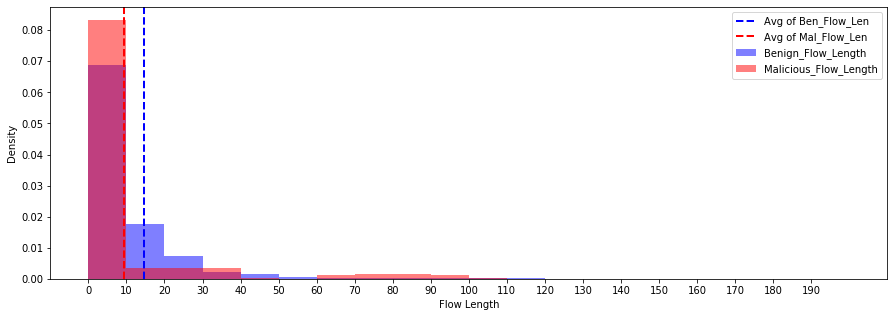

In [115]:
import matplotlib.pyplot as plt

plt.figure(figsize = (15,5))

plt.hist(ben_flow_len, bins = 20, alpha = 0.5, range = (0,200), density = True, color = 'b', label = 'Benign_Flow_Length')
plt.hist(mal_flow_len, bins = 20, alpha = 0.5, range = (0,200), density = True, color = 'r', label = 'Malicious_Flow_Length')
plt.xticks(np.arange(0,200,10))

plt.axvline(pd.DataFrame(ben_flow_len).mean().item(), color='b', linestyle='dashed', linewidth=2, label = 'Avg of Ben_Flow_Len')
plt.axvline(pd.DataFrame(mal_flow_len).mean().item(), color='r', linestyle='dashed', linewidth=2, label = 'Avg of Mal_Flow_Len')

plt.legend()
plt.xlabel('Flow Length')
plt.ylabel('Density')

In [116]:
ben_over_3000 = 0
for i in tqdm(range(len(ben_pck_len))):
    if ben_pck_len[i] > 3000:
        ben_over_3000 +=1


100%|██████████| 32116795/32116795 [00:10<00:00, 3025040.12it/s]


In [117]:
mal_over_3000 = 0
for i in tqdm(range(len(mal_pck_len))):
    if mal_pck_len[i] > 3000:
        mal_over_3000 +=1


100%|██████████| 4457366/4457366 [00:01<00:00, 2833897.55it/s]


In [118]:
print(f'Percentage of Benign Packet Length Over 3000: {100 *ben_over_3000/len(ben_pck_len):.4f}%')

Percentage of Benign Packet Length Over 3000: 0.6875%


In [119]:
print(f'Percentage of Malicious Packet Length Over 3000: {100 *mal_over_3000/len(mal_pck_len):.4f}%')

Percentage of Malicious Packet Length Over 3000: 7.4546%


In [120]:
print(f'Average of Benign Packet Length : {pd.DataFrame(ben_pck_len).mean()}')

Average of Benign Packet Length : 0    533.184995
dtype: float64


In [121]:
print(f'Average of Malicious Packet Length : {pd.DataFrame(mal_pck_len).mean()}')

Average of Malicious Packet Length : 0    771.278879
dtype: float64


Text(0, 0.5, 'Density')

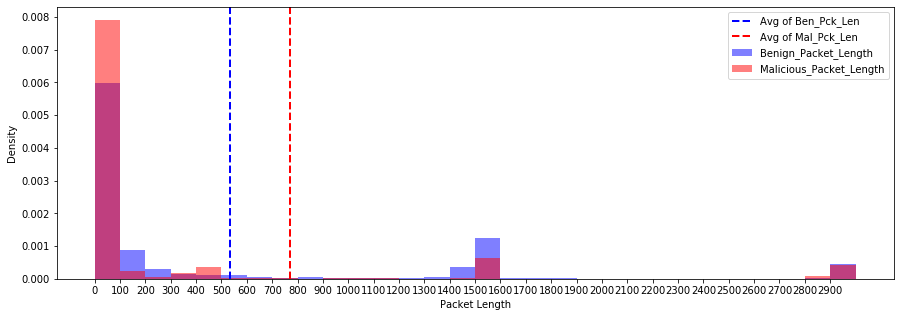

In [122]:
plt.figure(figsize = (15,5))

plt.hist(ben_pck_len, bins = 30, alpha = 0.5, range = (0,3000), density = True, color = 'b', label = 'Benign_Packet_Length')
plt.hist(mal_pck_len, bins = 30, alpha = 0.5, range = (0,3000), density = True, color = 'r', label = 'Malicious_Packet_Length')
plt.xticks(np.arange(0,3000,100))

plt.axvline(pd.DataFrame(ben_pck_len).mean().item(), color='b', linestyle='dashed', linewidth=2, label = 'Avg of Ben_Pck_Len')
plt.axvline(pd.DataFrame(mal_pck_len).mean().item(), color='r', linestyle='dashed', linewidth=2, label = 'Avg of Mal_Pck_Len')

plt.legend()

plt.xlabel('Packet Length')
plt.ylabel('Density')